# Классификация на FashionMNIST (ResNet)

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision as tv
import torchvision.models as models
import torch.optim as O

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
def peep(data, H, W):
    fig = plt.figure(figsize=(16,3*H))
    for i in range(H*W):
        fig.add_subplot(H, W, i+1)
        plt.imshow(data[int(np.random.choice(len(data), 1))][0].permute(1,2,0))
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()

In [4]:
class NetPipeline:
    def __init__(self, train_data, test_data, model, num_epochs, batch_size,  
                 first_opt, lr1, criterion=nn.CrossEntropyLoss(), second_opt=False, lr2=False):
        self.train_data = train_data
        self.test_data = test_data
        self.model = model
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = criterion
        self.first_opt = first_opt
        self.lr1 = lr1
        self.second_opt = second_opt
        self.lr2 = lr2
        
    def train_steps(self):
        self.model.to(device)
        self.loader()
        trainer_1 = self.first_opt((self.model).parameters(), lr=self.lr1)
        if self.second_opt: trainer_2 = self.second_opt(self.model.parameters(), lr=self.lr2)
        for epoch in range(self.num_epochs):
            start = time.time()
            self.first_train = self.training(self.train_loader, trainer=trainer_1)
            self.second_train = self.training(self.train_loader, trainer=trainer_2) if self.second_opt else False 
            self.last_train = self.training(self.test_loader, mode='eval')
            time_spent = time.time() - start
            self.printer(epoch, time_spent)
        self.model.to('cpu')
        torch.cuda.empty_cache()
        
    
    def loader(self):
        self.train_loader = torch.utils.data.DataLoader(dataset=self.train_data, 
                                                        batch_size=self.batch_size, 
                                                        shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.train_data, 
                                                       batch_size=self.batch_size, 
                                                       shuffle=False)
            
    
    def training(self, data, trainer=False, mode='train'):
        self.model.eval() if mode == 'eval' else self.model.train()
        dict = {'loss':0, 'tp':0, 'iters':0, 'len':0}
        for X, y in data:
            X, y = X.to(device), y.to(device)
            if mode == 'train': trainer.zero_grad()
            predictions = self.model(X)
            loss = self.criterion(predictions, y)
            loss.backward()
            if mode == 'train': trainer.step()
            dict = {'loss':(dict['loss']+loss.item()), 
                    'tp':(dict['tp']+(predictions.argmax(dim=1) == y).sum().item()), 
                    'iters':(dict['iters']+1), 
                    'len':(dict['len']+len(X))}
            del X, y, predictions, loss
        return {'loss':(dict['loss']/dict['iters']), 'acc':(dict['tp']/dict['len'])} 
            
    
    def printer (self, epoch, time_spent):
        name_1 = self.first_opt.__name__
        name_2 = self.second_opt.__name__ if self.second_opt else False
        if not epoch:
            print(self.model.__class__.__name__)
            print('|{: ^8}|{: ^9}|'.format('Epochs','Time') + \
                  '{: ^17}|{: ^16}|'.format('Train '+name_1+' loss', 'Train '+name_1+' acc') + \
                  ('{: ^17}|{: ^16}|'.format('Train '+str(name_2)+' loss', 
                                             'Train '+str(name_2)+' acc')if self.second_opt else '') + \
                  '{: ^11}|{: ^10}|'.format('Test loss', 'Test acc'))

        print('|{: ^8}|{: ^9.4f}|'.format(epoch, time_spent) + \
              '{: ^17.4f}|{: ^16.4%}|'.format(self.first_train['loss'], self.first_train['acc']) + \
              ('{: ^17.4f}|{: ^16.4%}|'.format(self.second_train['loss'], 
                                               self.second_train['acc'])if self.second_opt else '') + \
              '{: ^11.4f}|{: ^10.4%}|'.format(self.last_train['loss'], self.last_train['acc']))

Train data sample:


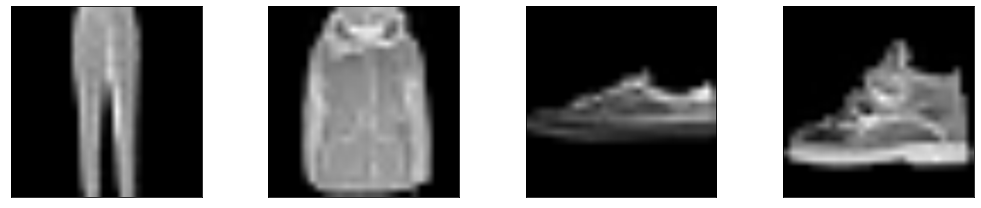

Test data sample:


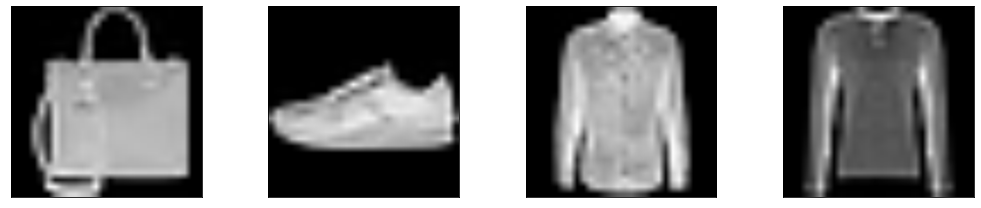

In [5]:
transforms = tv.transforms.Compose([tv.transforms.Grayscale(3), 
                                     tv.transforms.Resize((224,224)),
                                     tv.transforms.ToTensor()])

train = tv.datasets.FashionMNIST('.', train=True, transform=transforms, download=True)
test = tv.datasets.FashionMNIST('.', train=False, transform=transforms, download=True)
print('Train data sample:')
peep(train, 1, 4)
print('Test data sample:')
peep(test, 1, 4)

In [6]:
resnet18_prt_2 = models.resnet18(pretrained=True)
for param in resnet18_prt_2.parameters():
    param.requires_grad = False
resnet18_prt_2.fc = nn.Linear(in_features=512, out_features=10)

NetPipeline(train, test, 
            model=resnet18_prt_2, num_epochs=5, batch_size=30, 
            first_opt=O.SGD, lr1=.001 ).train_steps()

ResNet
| Epochs |  Time   | Train SGD loss  | Train SGD acc  | Test loss | Test acc |
|   0    |683.7022 |     1.1791      |    68.9200%    |  0.7446   | 78.9650% |
|   1    |588.5417 |     0.7024      |    79.3467%    |  0.6016   | 81.1583% |
|   2    |557.1959 |     0.6091      |    80.8483%    |  0.5455   | 82.1783% |
|   3    |541.0963 |     0.5643      |    81.6783%    |  0.5138   | 82.8917% |
|   4    |541.1352 |     0.5366      |    82.2733%    |  0.4926   | 83.3667% |


В итоге, использование предобученной модели ResNet18 себя не оправдало - на датасете FashionMNIST свёрточная нейронная сеть на 5 эпохе показывала accuracy 91%, при этом обучаясь по 60-70 секунд на эпоху. 